# Arm Motion Modeling

## System Description

A double-pendulum system hanging in gravity is shown in the figure above. $q=[\theta_1, \theta_2]$ are the system configuration variables. We assume the z-axis is pointing out from the screen/paper, thus the positive direction of rotation is counter-clockwise.
The solution steps are:
1. Computing the Lagrangian of the system. 
2. Computing the Euler-Lagrange equations, and solve them for $\ddot{\theta}_1$ and $\ddot{\theta}_2$.
3. Numerically evaluating the solutions for ${\tau}_1$ and ${\tau}_2$, and simulating the system for ${\theta}_1$, ${\theta}_2$, $\dot{\theta}_1$, $\dot{\theta}_2$, $\ddot{\theta}_1$ and $\ddot{\theta}_2$.
4. Animating the simulation.

In [2]:
from IPython.core.display import HTML
display(HTML("<table><tr><td><img src='images/double-pendulum.jpg' width=500' height='350'></table>"))

## Import Libraries and Define System Constants

Import libraries:

In [3]:
# Imports required for data processing
import os
import csv
import pandas as pd

# Imports required for dynamics calculations
import sympy
from sympy.abc import t
from sympy import symbols, Eq, Function, solve, sin, cos, Matrix, Subs, substitution, Derivative, simplify, symbols, lambdify
import math
from math import pi
import numpy as np
import matplotlib.pyplot as plt

# Imports required for animation
from plotly.offline import init_notebook_mode, iplot
from IPython.display import display, HTML
import plotly.graph_objects as go

Define the system's constants:

In [4]:
# Masses, length and center-of-mass positions (calculated using the lab measurements)
# Mass calculations (mass unit is kg) 
# m_body = 90.6                          # Average weights for American adult male
#                                        # from "Anthropometric Reference Data for Children and Adults:
#                                        # United States, 2015–2018"
m_body_dict = {'ID': 51, 'JD': 79.5, 'JR': 76, 'KS': 59.3, 'KW': 63.8, 'LC': 61.2,
               'LD': 97.3, 'LS': 82.2, 'MK': 93.5, 'MV': 98.5, 'SM': 68.5, 'TD': 70,
               'TM': 66.2}

# m_upper_arm = 0.028 * m_body           # Average upper arm weights relative to body weight, from “Biomechanics
#                                        # and Motor Control of Human Movement” by David Winter (2009), 4th edition
m_upper_arm_dict = {'ID': 0.028 * m_body_dict['ID'], 'JD': 0.028 * m_body_dict['JD'],
                    'JR': 0.028 * m_body_dict['JR'], 'KS': 0.028 * m_body_dict['KS'],
                    'KW': 0.028 * m_body_dict['KW'], 'LC': 0.028 * m_body_dict['LC'],
                    'LD': 0.028 * m_body_dict['LD'], 'LS': 0.028 * m_body_dict['LS'],
                    'MK': 0.028 * m_body_dict['MK'], 'MV': 0.028 * m_body_dict['MV'],
                    'SM': 0.028 * m_body_dict['SM'], 'TD': 0.028 * m_body_dict['TD'],
                    'TM': 0.028 * m_body_dict['TM']}

m_lower_arm = 0.7395                   # Average lower prosthetics weights, calculated using lab measurements  



# Arm length calculations (length unit is m) 
# H_body = 1.769                         # Average height for American adult male, from “Height and body-mass 
#                                        # index trajectories of school-aged children and adolescents from 
#                                        # 1985 to 2019 in 200 countries and territories: a pooled analysis 
#                                        # of 2181 population-based studies with 65 million participants”
H_body_dict = {'ID': 1.62, 'JD': 1.76, 'JR': 1.77, 'KS': 1.64, 'KW': 1.62, 'LC': 1.58,
               'LD': 1.875, 'LS': 1.635, 'MK': 1.78, 'MV': 1.805, 'SM': 1.79, 'TD': 1.69,
               'TM': 1.735}

# L_upper_arm = 0.186 * H_body           # Average upper arm length relative to body height
#                                        # from “Biomechanics and Motor Control of Human Movement” by David
#                                        # Winter (2009), 4th edition
L_upper_arm_dict = {'ID': 0.186 * H_body_dict['ID'], 'JD': 0.186 * H_body_dict['JD'],
                    'JR': 0.186 * H_body_dict['JR'], 'KS': 0.186 * H_body_dict['KS'],
                    'KW': 0.186 * H_body_dict['KW'], 'LC': 0.186 * H_body_dict['LC'],
                    'LD': 0.186 * H_body_dict['LD'], 'LS': 0.186 * H_body_dict['LS'],
                    'MK': 0.186 * H_body_dict['MK'], 'MV': 0.186 * H_body_dict['MV'],
                    'SM': 0.186 * H_body_dict['SM'], 'TD': 0.186 * H_body_dict['TD'],
                    'TM': 0.186 * H_body_dict['TM']}

L_lower_arm = 0.42                     # Average lower prosthetics length, calculated using lab measurements 



# Arm center of mass length calculations (length unit is m) 
# L_upper_arm_COM = 0.436 * L_upper_arm  # Average upper arm length from shoulder to center of mass relative
#                                        # to upper arm length, from “Biomechanics and Motor Control of Human
#                                        # Movement” by David Winter (2009), 4th edition
L_upper_arm_COM_dict = {'ID': 0.436 * L_upper_arm_dict['ID'], 'JD': 0.436 * L_upper_arm_dict['JD'],
                        'JR': 0.436 * L_upper_arm_dict['JR'], 'KS': 0.436 * L_upper_arm_dict['KS'],
                        'KW': 0.436 * L_upper_arm_dict['KW'], 'LC': 0.436 * L_upper_arm_dict['LC'],
                        'LD': 0.436 * L_upper_arm_dict['LD'], 'LS': 0.436 * L_upper_arm_dict['LS'],
                        'MK': 0.436 * L_upper_arm_dict['MK'], 'MV': 0.436 * L_upper_arm_dict['MV'],
                        'SM': 0.436 * L_upper_arm_dict['SM'], 'TD': 0.436 * L_upper_arm_dict['TD'],
                        'TM': 0.436 * L_upper_arm_dict['TM']}
    
L_lower_arm_COM = 0.2388               # Average lower prosthetics length from elbow to center of mass,
                                       # calculated using lab measurements 

## Extracting Data

Extracting angles data and computing angular valocities and angular accelerations from the angles:

In [5]:
def calculate_Vel(Ang_list, time_list, index):
    return ((Ang_list[index+1] - Ang_list[index])
          / (time_list[index+1] - time_list[index]))


def calculate_Acc(Vel_list, time_list, index):
    return ((Vel_list[index+1] - Vel_list[index])
          / (time_list[index+1] - time_list[index]))


data_csv_dir = './data/Control Data/CSV Converted Files'
frame_frequency = 120
print("current directory: ", os.getcwd())

participants_list = []
time_list = []
Elbow_Ang_list = []
Shl_Flex_Ang_list = []
Elbow_Vel_list = []
Shl_Flex_Vel_list = []
Elbow_Acc_list = []
Shl_Flex_Acc_list = []

for file in os.listdir(data_csv_dir):
    file_name = file.split(".")[0]
    participant_name = file.split("_")[0]
    
    if file.endswith(".csv"):
        frame = 0
        file_time_list = []
        file_R_Elbow_Ang_list = []
        file_R_Shl_Flex_Ang_list = []
        file_L_Elbow_Ang_list = []
        file_L_Shl_Flex_Ang_list = []
        file_R_Elbow_Vel_list = []
        file_R_Shl_Flex_Vel_list = []
        file_L_Elbow_Vel_list = []
        file_L_Shl_Flex_Vel_list = []
        file_R_Elbow_Acc_list = []
        file_R_Shl_Flex_Acc_list = []
        file_L_Elbow_Acc_list = []
        file_L_Shl_Flex_Acc_list = []

        data_path = os.path.join(data_csv_dir, file)
        
        # Cutting out weird data behavior on data edges
        if file == 'TD_WN7.csv':
            data_rows = open(data_path).read().strip().split("\n")[40:]
        elif file == 'TD_WN4.csv':
            data_rows = open(data_path).read().strip().split("\n")[24:-12]    
        elif file == 'TD_WN11.csv':
            data_rows = open(data_path).read().strip().split("\n")[24:-3]               
        else:
            data_rows = open(data_path).read().strip().split("\n")[24:]
        
        # Extract time [sec], elbow angles [rad], and shoulder angles [rad] from data
        for row in data_rows:
            splitted_row = row.strip().split("\t")

            # Check if loop finished all data
            if len(splitted_row) < 80:
                break

            file_time_list.append(frame/frame_frequency)
            file_R_Elbow_Ang_list.append(float(splitted_row[9]) * 2*pi/360)
            file_R_Shl_Flex_Ang_list.append(float(splitted_row[11]) * 2*pi/360)
            file_L_Elbow_Ang_list.append(float(splitted_row[21]) * 2*pi/360)
            file_L_Shl_Flex_Ang_list.append(float(splitted_row[23]) * 2*pi/360)
            frame += 1

        # Extract elbow and shoulder velocities [rad/sec] from angles
        for i in range(len(file_time_list) - 1):
            R_Elbow_Vel = calculate_Vel(file_R_Elbow_Ang_list, file_time_list, i)
            R_Shl_Flex_Vel = calculate_Vel(file_R_Shl_Flex_Ang_list, file_time_list, i)
            L_Elbow_Vel = calculate_Vel(file_L_Elbow_Ang_list, file_time_list, i)
            L_Shl_Flex_Vel = calculate_Vel(file_L_Shl_Flex_Ang_list, file_time_list, i)
            
            file_R_Elbow_Vel_list.append(R_Elbow_Vel)
            file_R_Shl_Flex_Vel_list.append(R_Shl_Flex_Vel)
            file_L_Elbow_Vel_list.append(L_Elbow_Vel)
            file_L_Shl_Flex_Vel_list.append(L_Shl_Flex_Vel)

        # Extract elbow and shoulder Accelerations [rad/sec^2] from velocities
        for i in range(len(file_time_list) - 2):
            R_Elbow_Acc = calculate_Acc(file_R_Elbow_Vel_list, file_time_list, i)
            R_Shl_Flex_Acc = calculate_Acc(file_R_Shl_Flex_Vel_list, file_time_list, i)
            L_Elbow_Acc = calculate_Acc(file_L_Elbow_Vel_list, file_time_list, i)
            L_Shl_Flex_Acc = calculate_Acc(file_L_Shl_Flex_Vel_list, file_time_list, i)
            
            file_R_Elbow_Acc_list.append(R_Elbow_Acc)
            file_R_Shl_Flex_Acc_list.append(R_Shl_Flex_Acc)
            file_L_Elbow_Acc_list.append(L_Elbow_Acc)
            file_L_Shl_Flex_Acc_list.append(L_Shl_Flex_Acc)

        # Adjust lists length
        file_time_list = file_time_list[:-2]
        file_R_Elbow_Ang_list = file_R_Elbow_Ang_list[:-2]
        file_R_Shl_Flex_Ang_list = file_R_Shl_Flex_Ang_list[:-2]
        file_L_Elbow_Ang_list = file_L_Elbow_Ang_list[:-2]
        file_L_Shl_Flex_Ang_list = file_L_Shl_Flex_Ang_list[:-2]

        file_R_Elbow_Vel_list = file_R_Elbow_Vel_list[:-1]
        file_R_Shl_Flex_Vel_list = file_R_Shl_Flex_Vel_list[:-1]
        file_L_Elbow_Vel_list = file_L_Elbow_Vel_list[:-1]
        file_L_Shl_Flex_Vel_list = file_L_Shl_Flex_Vel_list[:-1]

        participants_list.append(participant_name)
        participants_list.append(participant_name)

        time_list.append(file_time_list)
        time_list.append(file_time_list)

        Elbow_Ang_list.append(file_R_Elbow_Ang_list)
        Shl_Flex_Ang_list.append(file_R_Shl_Flex_Ang_list)        
        Elbow_Ang_list.append(file_L_Elbow_Ang_list)
        Shl_Flex_Ang_list.append(file_L_Shl_Flex_Ang_list)
        Elbow_Vel_list.append(file_R_Elbow_Vel_list)
        Shl_Flex_Vel_list.append(file_R_Shl_Flex_Vel_list)        
        Elbow_Vel_list.append(file_L_Elbow_Vel_list)
        Shl_Flex_Vel_list.append(file_L_Shl_Flex_Vel_list)
        Elbow_Acc_list.append(file_R_Elbow_Acc_list)
        Shl_Flex_Acc_list.append(file_R_Shl_Flex_Acc_list)        
        Elbow_Acc_list.append(file_L_Elbow_Acc_list)
        Shl_Flex_Acc_list.append(file_L_Shl_Flex_Acc_list)

current directory:  /home/yael/Documents/MSR_Courses/Spring_2021/ME499-Final_Project/Motorized-Prosthetic-Arm


## System Modeling

Computing the Lagrangian of the system:

In [6]:
m1, m2, g, R1, R1_COM, R2, R2_COM = symbols(r'm1, m2, g, R1, R1_COM, R2, R2_COM')

# The system torque variables as function of t
tau1 = Function(r'tau1')(t)
tau2 = Function(r'tau2')(t)

# The system configuration variables as function of t
theta1 = Function(r'theta1')(t)
theta2 = Function(r'theta2')(t)

# The velocity as derivative of position wrt t
theta1_dot = theta1.diff(t)
theta2_dot = theta2.diff(t)

# The acceleration as derivative of velocity wrt t
theta1_ddot = theta1_dot.diff(t)
theta2_ddot = theta2_dot.diff(t)

# Converting the polar coordinates to cartesian coordinates
x1 = R1_COM*sin(theta1)
x2 = R1*sin(theta1) + R2_COM*sin(theta1 + theta2)

y1 = -R1_COM*cos(theta1)
y2 = -R1*cos(theta1) - R2_COM*cos(theta1 + theta2)

# Calculating the kinetic and potential energy of the system
KE = 1/2*m1*((x1.diff(t))**2 + (y1.diff(t))**2) + 1/2*m2*((x2.diff(t))**2 + (y2.diff(t))**2)
PE = m1*g*y1 + m2*g*y2

# Computing the Lagrangian
L = simplify(KE - PE)
print('L: ')
display(L)

L: 


0.5*R1_COM**2*m1*Derivative(theta1(t), t)**2 + R1_COM*g*m1*cos(theta1(t)) + g*m2*(R1*cos(theta1(t)) + R2_COM*cos(theta1(t) + theta2(t))) + 0.5*m2*(R1**2*Derivative(theta1(t), t)**2 + 2*R1*R2_COM*cos(theta2(t))*Derivative(theta1(t), t)**2 + 2*R1*R2_COM*cos(theta2(t))*Derivative(theta1(t), t)*Derivative(theta2(t), t) + R2_COM**2*Derivative(theta1(t), t)**2 + 2*R2_COM**2*Derivative(theta1(t), t)*Derivative(theta2(t), t) + R2_COM**2*Derivative(theta2(t), t)**2)

Computing the Euler-Lagrange equations:

In [7]:
# Define the derivative of L wrt the functions: x, xdot
L_dtheta1 = L.diff(theta1)
L_dtheta2 = L.diff(theta2)

L_dtheta1_dot = L.diff(theta1_dot)
L_dtheta2_dot = L.diff(theta2_dot)

# Define the derivative of L_dxdot wrt to time t
L_dtheta1_dot_dt = L_dtheta1_dot.diff(t)
L_dtheta2_dot_dt = L_dtheta2_dot.diff(t)

# Define the left hand side of the the Euler-Lagrange as a matrix
lhs = Matrix([simplify(L_dtheta1_dot_dt - L_dtheta1),
              simplify(L_dtheta2_dot_dt - L_dtheta2)])

# Define the right hand side of the the Euler-Lagrange as a Matrix
rhs = Matrix([tau1, tau2])

# Compute the Euler-Lagrange equations as a matrix
EL_eqns = Eq(lhs, rhs)

print('Euler-Lagrange matrix for this systems:')
display(EL_eqns)

Euler-Lagrange matrix for this systems:


Eq(Matrix([
[1.0*R1_COM**2*m1*Derivative(theta1(t), (t, 2)) + R1_COM*g*m1*sin(theta1(t)) + g*m2*(R1*sin(theta1(t)) + R2_COM*sin(theta1(t) + theta2(t))) + m2*(R1**2*Derivative(theta1(t), (t, 2)) - 2*R1*R2_COM*sin(theta2(t))*Derivative(theta1(t), t)*Derivative(theta2(t), t) - R1*R2_COM*sin(theta2(t))*Derivative(theta2(t), t)**2 + 2*R1*R2_COM*cos(theta2(t))*Derivative(theta1(t), (t, 2)) + R1*R2_COM*cos(theta2(t))*Derivative(theta2(t), (t, 2)) + R2_COM**2*Derivative(theta1(t), (t, 2)) + R2_COM**2*Derivative(theta2(t), (t, 2)))],
[                                                                                                                                                                                                                                                                                                           R2_COM*m2*(R1*sin(theta2(t))*Derivative(theta1(t), t)**2 + R1*cos(theta2(t))*Derivative(theta1(t), (t, 2)) + R2_COM*Derivative(theta1(t), (t, 2)) + R2_COM*Derivative(the

Solve the equations for ${\tau}_1$ and ${\tau}_2$:

In [8]:
# Solve the Euler-Lagrange equations for the shoulder and elbow torques
T = Matrix([tau1, tau2])
soln = solve(EL_eqns, T, dict=True)

# Initialize the solutions
solution = [0, 0]
i = 0

for sol in soln:
    for v in T:
        solution[i] = simplify(sol[v])
        display(Eq(T[i], solution[i]))
        i =+ 1

Eq(tau1(t), R1**2*m2*Derivative(theta1(t), (t, 2)) - 2.0*R1*R2_COM*m2*sin(theta2(t))*Derivative(theta1(t), t)*Derivative(theta2(t), t) - R1*R2_COM*m2*sin(theta2(t))*Derivative(theta2(t), t)**2 + 2.0*R1*R2_COM*m2*cos(theta2(t))*Derivative(theta1(t), (t, 2)) + R1*R2_COM*m2*cos(theta2(t))*Derivative(theta2(t), (t, 2)) + R1*g*m2*sin(theta1(t)) + R1_COM**2*m1*Derivative(theta1(t), (t, 2)) + R1_COM*g*m1*sin(theta1(t)) + R2_COM**2*m2*Derivative(theta1(t), (t, 2)) + R2_COM**2*m2*Derivative(theta2(t), (t, 2)) + R2_COM*g*m2*sin(theta1(t) + theta2(t)))

Eq(tau2(t), R2_COM*m2*(R1*sin(theta2(t))*Derivative(theta1(t), t)**2 + R1*cos(theta2(t))*Derivative(theta1(t), (t, 2)) + R2_COM*Derivative(theta1(t), (t, 2)) + R2_COM*Derivative(theta2(t), (t, 2)) + g*sin(theta1(t) + theta2(t))))

Simulating the system:

In [9]:
# Substitute the derivative variables with a dummy variables and plug-in the constants
solution_0_subs = solution[0]
solution_1_subs = solution[1]

theta1_dot_dummy = symbols('dtheta1')
theta2_dot_dummy = symbols('dtheta2')
theta1_ddot_dummy = symbols('ddtheta1')
theta2_ddot_dummy = symbols('ddtheta2')

# solution_0_subs = solution_0_subs.subs([(m1, m_upper_arm), (m2, m_lower_arm), (R1, L_upper_arm), (R2, L_lower_arm), (R1_COM, L_upper_arm_COM), (R2_COM, L_lower_arm_COM), (g, 9.81)])
# solution_1_subs = solution_1_subs.subs([(m1, m_upper_arm), (m2, m_lower_arm), (R1, L_upper_arm), (R2, L_lower_arm), (R1_COM, L_upper_arm_COM), (R2_COM, L_lower_arm_COM), (g, 9.81)])

solution_0_subs = solution_0_subs.subs([(g, 9.81)])
solution_1_subs = solution_1_subs.subs([(g, 9.81)])

# display(Eq(T[0], solution_0_subs))
# display(Eq(T[1], solution_1_subs))

solution_0_subs = solution_0_subs.subs([((theta1.diff(t)).diff(t), theta1_ddot_dummy),
                                        ((theta2.diff(t)).diff(t), theta2_ddot_dummy)])
solution_1_subs = solution_1_subs.subs([((theta1.diff(t)).diff(t), theta1_ddot_dummy),
                                        ((theta2.diff(t)).diff(t), theta2_ddot_dummy)])

solution_0_subs = solution_0_subs.subs([(theta1.diff(t), theta1_dot_dummy),
                                        (theta2.diff(t), theta2_dot_dummy)])
solution_1_subs = solution_1_subs.subs([(theta1.diff(t), theta1_dot_dummy),
                                        (theta2.diff(t), theta2_dot_dummy)])

# Lambdify the thetas and its derivatives
func1 = lambdify([theta1, theta2, theta1_dot_dummy, theta2_dot_dummy, theta1_ddot_dummy,
                  theta2_ddot_dummy, m1, m2, R1, R2, R1_COM, R2_COM], solution_0_subs, modules = sympy)
func2 = lambdify([theta1, theta2, theta1_dot_dummy, theta2_dot_dummy, theta1_ddot_dummy,
                  theta2_ddot_dummy, m1, m2, R1, R2, R1_COM, R2_COM], solution_1_subs, modules = sympy)

# Initialize the torque and power lists
Shl_Flex_tau_list, Elbow_tau_list = [], []
Shl_Flex_power_list, Elbow_power_list = [], []

for i in range(len(time_list)):
    # Initialize the torque and power lists
    tau1_list, tau2_list = [], []
    power1_list, power2_list = [], []

    t_list = time_list[i]
    theta1_list = Shl_Flex_Ang_list[i]
    theta2_list = Elbow_Ang_list[i]
    dtheta1_list = Shl_Flex_Vel_list[i]
    dtheta2_list = Elbow_Vel_list[i]
    ddtheta1_list = Shl_Flex_Acc_list[i]
    ddtheta2_list = Elbow_Acc_list[i]

    # Plug-in the angles, angular velocities and angular accelerations for every time step to find the torques
    for j in range(len(t_list)):
        tau1_list.append(func1(theta1_list[j], theta2_list[j], dtheta1_list[j], dtheta2_list[j],
                               ddtheta1_list[j], ddtheta2_list[j], m_upper_arm_dict[participants_list[i]],
                               m_lower_arm, L_upper_arm_dict[participants_list[i]], L_lower_arm,
                               L_upper_arm_COM_dict[participants_list[i]], L_lower_arm_COM))
        
        tau2_list.append(func2(theta1_list[j], theta2_list[j], dtheta1_list[j], dtheta2_list[j],
                               ddtheta1_list[j], ddtheta2_list[j], m_upper_arm_dict[participants_list[i]],
                               m_lower_arm, L_upper_arm_dict[participants_list[i]], L_lower_arm,
                               L_upper_arm_COM_dict[participants_list[i]], L_lower_arm_COM))

        # Calculate the power required to reach the required angular velociries and joints torques for every time step
        power1_list.append(dtheta1_list[j] * tau1_list[j])
        power2_list.append(dtheta2_list[j] * tau2_list[j])
    
    Shl_Flex_tau_list.append(tau1_list)
    Elbow_tau_list.append(tau2_list)
    
    Shl_Flex_power_list.append(power1_list)
    Elbow_power_list.append(power2_list)   
    
    print(f"Trial {i}/{len(time_list)-1} finished \t maximum torque is {format(max(tau2_list), '.3f')} [Nm]\t maximum power is {format(max(power2_list), '.3f')} [W]")

Trial 0/203 finished 	 maximum torque is 1.929 [Nm]	 maximum power is 0.968 [W]
Trial 1/203 finished 	 maximum torque is 2.216 [Nm]	 maximum power is 2.258 [W]
Trial 2/203 finished 	 maximum torque is 3.126 [Nm]	 maximum power is 3.431 [W]
Trial 3/203 finished 	 maximum torque is 3.753 [Nm]	 maximum power is 2.448 [W]
Trial 4/203 finished 	 maximum torque is 2.113 [Nm]	 maximum power is 2.634 [W]
Trial 5/203 finished 	 maximum torque is 2.409 [Nm]	 maximum power is 4.074 [W]
Trial 6/203 finished 	 maximum torque is 1.745 [Nm]	 maximum power is 2.063 [W]
Trial 7/203 finished 	 maximum torque is 2.379 [Nm]	 maximum power is 1.769 [W]
Trial 8/203 finished 	 maximum torque is 2.085 [Nm]	 maximum power is 1.952 [W]
Trial 9/203 finished 	 maximum torque is 2.202 [Nm]	 maximum power is 1.177 [W]
Trial 10/203 finished 	 maximum torque is 2.498 [Nm]	 maximum power is 2.797 [W]
Trial 11/203 finished 	 maximum torque is 3.138 [Nm]	 maximum power is 3.980 [W]
Trial 12/203 finished 	 maximum torque

Trial 102/203 finished 	 maximum torque is 1.947 [Nm]	 maximum power is 1.375 [W]
Trial 103/203 finished 	 maximum torque is 1.990 [Nm]	 maximum power is 2.304 [W]
Trial 104/203 finished 	 maximum torque is 2.212 [Nm]	 maximum power is 3.225 [W]
Trial 105/203 finished 	 maximum torque is 3.599 [Nm]	 maximum power is 4.341 [W]
Trial 106/203 finished 	 maximum torque is 2.234 [Nm]	 maximum power is 2.158 [W]
Trial 107/203 finished 	 maximum torque is 2.002 [Nm]	 maximum power is 1.892 [W]
Trial 108/203 finished 	 maximum torque is 2.106 [Nm]	 maximum power is 2.203 [W]
Trial 109/203 finished 	 maximum torque is 1.893 [Nm]	 maximum power is 0.919 [W]
Trial 110/203 finished 	 maximum torque is 2.191 [Nm]	 maximum power is 1.887 [W]
Trial 111/203 finished 	 maximum torque is 2.268 [Nm]	 maximum power is 1.469 [W]
Trial 112/203 finished 	 maximum torque is 1.966 [Nm]	 maximum power is 1.381 [W]
Trial 113/203 finished 	 maximum torque is 2.072 [Nm]	 maximum power is 2.131 [W]
Trial 114/203 fi

Trial 202/203 finished 	 maximum torque is 1.546 [Nm]	 maximum power is 1.681 [W]
Trial 203/203 finished 	 maximum torque is 1.603 [Nm]	 maximum power is 1.502 [W]


Calculation summary:

In [10]:
# print(f"Shoulder max angular velocity:\t{format(max(dtheta1_list), '.3f')} [rad/sec]\t\t Shoulder average angular velocity:\t{format(sum(dtheta1_list) / float(len(dtheta1_list)), '.3f')} [rad/sec]")
# print(f"Shoulder max angular velocity:\t{format(max(dtheta1_list)*60/(2*pi), '.3f')} [rpm]\t\t Shoulder average angular velocity:\t{format((sum(dtheta1_list) / float(len(dtheta1_list)))*60/(2*pi), '.3f')} [rpm]")
# print(f"Elbow max angular velocity:\t{format(max(dtheta2_list), '.3f')} [rad/sec]\t\t Elbow average angular velocity:\t{format(sum(dtheta2_list) / float(len(dtheta2_list)), '.3f')} [rad/sec]")
# print(f"Elbow max angular velocity:\t{format(max(dtheta2_list)*60/(2*pi), '.3f')} [rpm]\t\t Elbow average angular velocity:\t{format((sum(dtheta2_list) / float(len(dtheta2_list)))*60/(2*pi), '.3f')} [rpm]\n")
# print(f"Shoulder max torque:\t\t{format(max(tau1_list), '.3f')} [Nm]\t\t Shoulder average torque:\t\t{format(sum(tau1_list) / float(len(tau1_list)), '.3f')} [Nm]")
# print(f"Elbow max torque:\t\t{format(max(tau2_list), '.3f')} [Nm]\t\t Elbow average torque:\t\t\t{format(sum(tau2_list) / float(len(tau2_list)), '.3f')} [Nm]\n")
# print(f"Shoulder max power:\t\t{format(max(power1_list), '.3f')} [W]\t\t Shoulder average power:\t\t{format(sum(power1_list) / float(len(power1_list)), '.3f')} [W]")
# print(f"Elbow max power:\t\t{format(max(power2_list), '.3f')} [W]\t\t Elbow average power:\t\t\t{format(sum(power2_list) / float(len(power2_list)), '.3f')} [W]\n")

max_Elbow_tau, max_Elbow_power, max_Elbow_Vel = 0, 0, 0
max_Elbow_tau_index, max_Elbow_power_index, max_Elbow_Vel_index = 0, 0, 0

for i in range(len(Elbow_tau_list)):
    if max_Elbow_Vel < max(Elbow_Vel_list[i]):
        max_Elbow_Vel = max(Elbow_Vel_list[i])
        max_Elbow_Vel_index = i
        
    if max_Elbow_tau < max(Elbow_tau_list[i]):
        max_Elbow_tau = max(Elbow_tau_list[i])
        max_Elbow_tau_index = i
        
    if max_Elbow_power < max(Elbow_power_list[i]):
        max_Elbow_power = max(Elbow_power_list[i])
        max_Elbow_power_index = i

print(f"maximum elbow angular velocity is {format(max_Elbow_Vel, '.3f')} [rad/sec] ({format(max_Elbow_Vel*60/(2*pi), '.3f')} [rpm]), in trial {max_Elbow_Vel_index}")
print(f"maximum elbow torque is {format(max_Elbow_tau, '.3f')} [Nm], in trial {max_Elbow_tau_index}")
print(f"maximum elbow power is {format(max_Elbow_power, '.3f')} [W], in trial {max_Elbow_power_index}")

maximum elbow angular velocity is 4.143 [rad/sec] (39.560 [rpm]), in trial 69
maximum elbow torque is 4.763 [Nm], in trial 125
maximum elbow power is 7.720 [W], in trial 125


Example for the trial with the largest elbow torque & power:

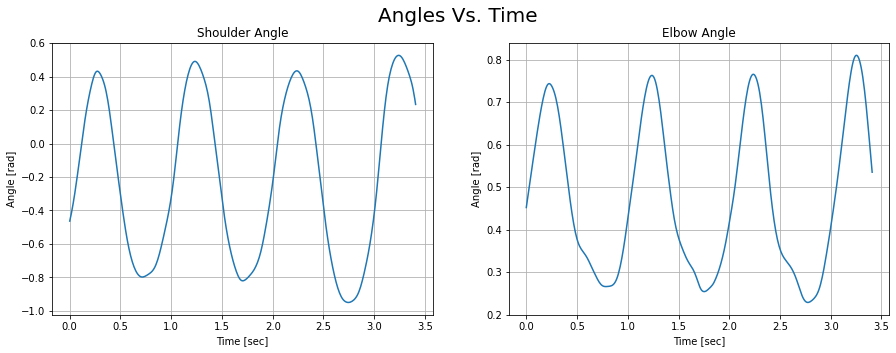

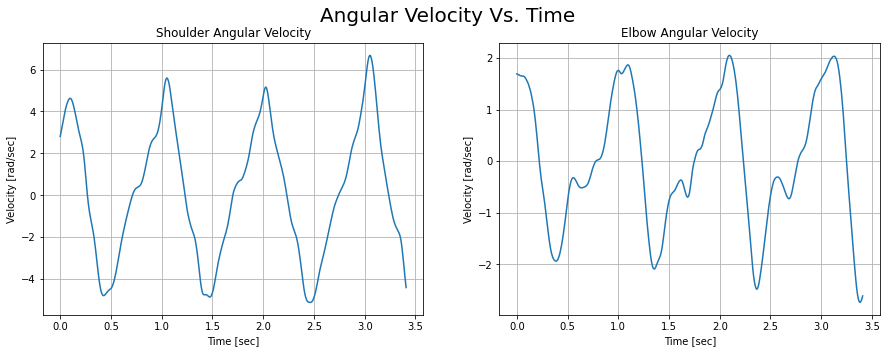

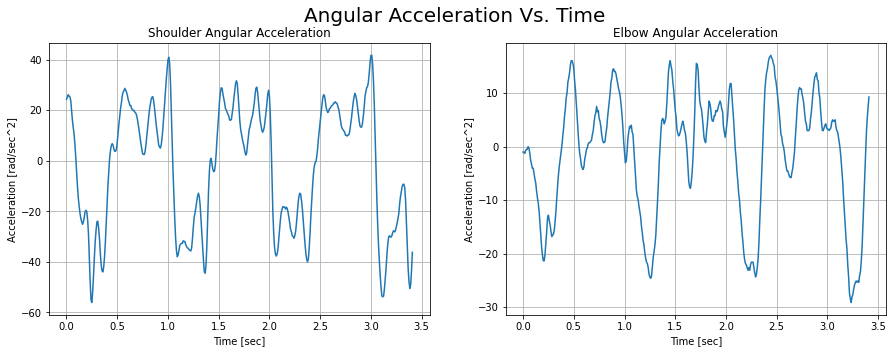

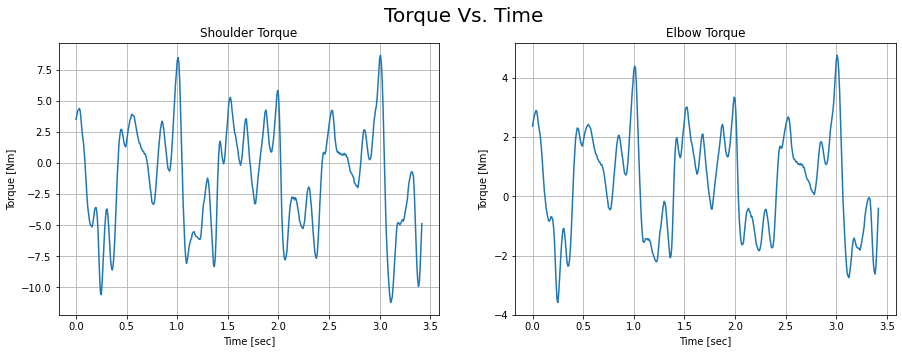

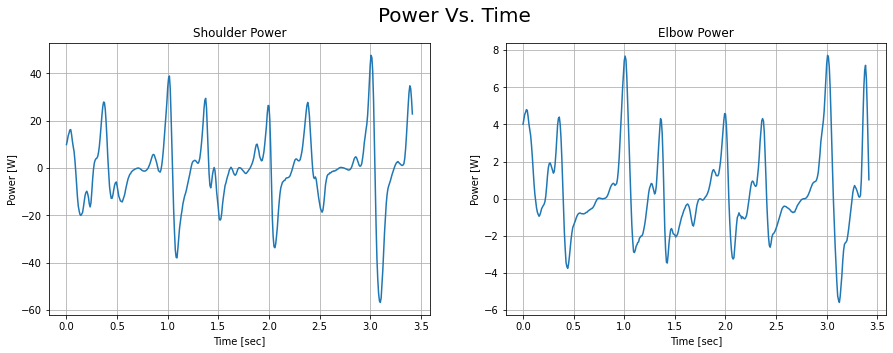

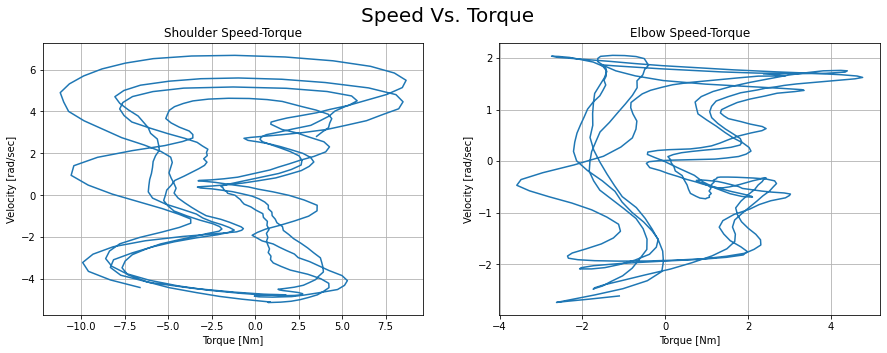

In [11]:
index = 125
t_list = time_list[index]
theta1_list = Shl_Flex_Ang_list[index]
theta2_list = Elbow_Ang_list[index]
dtheta1_list = Shl_Flex_Vel_list[index]
dtheta2_list = Elbow_Vel_list[index]
ddtheta1_list = Shl_Flex_Acc_list[index]
ddtheta2_list = Elbow_Acc_list[index]
tau1_list = Shl_Flex_tau_list[index]
tau2_list = Elbow_tau_list[index]
power1_list = Shl_Flex_power_list[index]
power2_list = Elbow_power_list[index]

# Compute the trajectory of the arm's motion
N = int((max(t_list) - min(t_list))/(1/frame_frequency))
tvec = np.linspace(min(t_list), max(t_list), N)
traj = np.zeros((6, N))
for i in range(N):
    traj[0, i] = theta1_list[i]
    traj[1, i] = theta2_list[i]
    traj[2, i] = dtheta1_list[i]
    traj[3, i] = dtheta2_list[i]
    traj[4, i] = ddtheta1_list[i]
    traj[5, i] = ddtheta2_list[i]

# Calculate the length difference between the time list and the trajectory lists
diff = (len(t_list) - len(traj[0]))

# Plot the trajectory lists (angles, velocities, accelerations, torques, and power)
plt.figure(figsize=(15,5))
plt.suptitle('Angles Vs. Time', fontsize=20)
plt.subplot(121)
plt.plot(t_list[:-diff], traj[0])
plt.ylabel('Angle [rad]')
plt.xlabel('Time [sec]')
plt.grid()
plt.title('Shoulder Angle')

plt.subplot(122)
plt.plot(t_list[:-diff], traj[1])
plt.ylabel('Angle [rad]')
plt.xlabel('Time [sec]')
plt.grid()
plt.title('Elbow Angle')
plt.show()

plt.figure(figsize=(15,5))
plt.suptitle('Angular Velocity Vs. Time', fontsize=20)
plt.subplot(121)
plt.plot(t_list[:-diff], traj[2])
plt.ylabel('Velocity [rad/sec]')
plt.xlabel('Time [sec]')
plt.grid()
plt.title('Shoulder Angular Velocity')

plt.subplot(122)
plt.plot(t_list[:-diff], traj[3])
plt.ylabel('Velocity [rad/sec]')
plt.xlabel('Time [sec]')
plt.grid()
plt.title('Elbow Angular Velocity')
plt.show()

plt.figure(figsize=(15,5))
plt.suptitle('Angular Acceleration Vs. Time', fontsize=20)
plt.subplot(121)
plt.plot(t_list[:-diff], traj[4])
plt.ylabel('Acceleration [rad/sec^2]')
plt.xlabel('Time [sec]')
plt.grid()
plt.title('Shoulder Angular Acceleration')

plt.subplot(122)
plt.plot(t_list[:-diff], traj[5])
plt.ylabel('Acceleration [rad/sec^2]')
plt.xlabel('Time [sec]')
plt.grid()
plt.title('Elbow Angular Acceleration')
plt.show()

plt.figure(figsize=(15,5))
plt.suptitle('Torque Vs. Time', fontsize=20)
plt.subplot(121)
plt.plot(t_list, tau1_list)
plt.ylabel('Torque [Nm]')
plt.xlabel('Time [sec]')
plt.grid()
plt.title('Shoulder Torque')

plt.subplot(122)
plt.plot(t_list, tau2_list)
plt.ylabel('Torque [Nm]')
plt.xlabel('Time [sec]')
plt.grid()
plt.title('Elbow Torque')
plt.show()

plt.figure(figsize=(15,5))
plt.suptitle('Power Vs. Time', fontsize=20)
plt.subplot(121)
plt.plot(t_list, power1_list)
plt.ylabel('Power [W]')
plt.xlabel('Time [sec]')
plt.grid()
plt.title('Shoulder Power')

plt.subplot(122)
plt.plot(t_list, power2_list)
plt.ylabel('Power [W]')
plt.xlabel('Time [sec]')
plt.grid()
plt.title('Elbow Power')
plt.show()

plt.figure(figsize=(15,5))
plt.suptitle('Speed Vs. Torque', fontsize=20)
plt.subplot(121)
plt.plot(tau1_list[:-diff], traj[2])
plt.ylabel('Velocity [rad/sec]')
plt.xlabel('Torque [Nm]')
plt.grid()
plt.title('Shoulder Speed-Torque')

plt.subplot(122)
plt.plot(tau2_list[:-diff], traj[3])
plt.ylabel('Velocity [rad/sec]')
plt.xlabel('Torque [Nm]')
plt.grid()
plt.title('Elbow Speed-Torque')
plt.show()

Animating the simulation:

In [12]:
def animate_double_pend(traj, L1, L2, L1_COM, L2_COM, T):
    """
    Function to generate web-based animation of double-pendulum system

    Parameters:
        traj:        trajectory of theta1 and theta2
        L1:          length of the upper arm
        L2:          length of the lower arm 
        L1_COM:      length of the center of mass of the upper arm from the shoulder 
        L2_COM:      length of the center of mass of the lower arm from the elbow
        T:           length/seconds of animation duration
        
    Returns: None
    """

    # Browser configuration
    def configure_plotly_browser_state():
        import IPython
        display(IPython.core.display.HTML('''
            <script src="/static/components/requirejs/require.js"></script>
            <script>
              requirejs.config({
                paths: {
                  base: '/static/base',
                  plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
                },
              });
            </script>
            '''))
    configure_plotly_browser_state()
    init_notebook_mode(connected=False)

    # Getting data from pendulum angle trajectories
    xx1 = L1 * np.sin(traj[0])
    yy1 = -L1 * np.cos(traj[0])
    xx1_COM = L1_COM * np.sin(traj[0])
    yy1_COM = -L1_COM * np.cos(traj[0])
    xx2 = xx1 + L2 * np.sin(traj[0] + traj[1])
    yy2 = yy1 - L2 * np.cos(traj[0] + traj[1])
    xx2_COM = xx1 + L2_COM * np.sin(traj[0] + traj[1])
    yy2_COM = yy1 - L2_COM * np.cos(traj[0] + traj[1])
    N = len(traj[0])

    # Using these to specify axis limits
    xm = np.min(xx1)
    xM = np.max(xx1)
    ym = np.min(yy1) - 0.6
    yM = np.max(yy1) + 0.6

    # Defining data dictionary
    data = [dict(x=xx1, y=yy1, 
                 mode='lines', name='Arm', 
                 line=dict(width=5, color='blue')
                ),
            dict(x=xx1_COM, y=yy1_COM, 
                 mode='lines', name='Upper Arm Center of Mass',
                 line=dict(width=2, color='green')
                ),
            dict(x=xx2_COM, y=yy2_COM, 
                 mode='lines', name='Lower Arm Center of Mass',
                 line=dict(width=2, color='orange')
                ),
            dict(x=xx1, y=yy1, 
                 mode='markers', name='Elbow Trajectory', 
                 marker=dict(color="green", size=2)
                ),
            dict(x=xx2, y=yy2, 
                 mode='markers', name='Hand Trajectory', 
                 marker=dict(color="orange", size=2)
                )
          ]

    # Preparing simulation layout
    layout = dict(xaxis=dict(range=[xm, xM], autorange=False, zeroline=False,dtick=1),
                  yaxis=dict(range=[ym, yM], autorange=False, zeroline=False,scaleanchor = "x",dtick=1),
                  title='Simulation of Arm Modeled as a Double Pendulum', 
                  hovermode='closest',
                  updatemenus= [{'type': 'buttons',
                                 'buttons': [{'label': 'Play', 'method': 'animate',
                                              'args': [None, {'frame': {'duration': T, 'redraw': False}}]},
                                             {'args': [[None], {'frame': {'duration': T, 'redraw': False}, 'mode': 'immediate',
                                              'transition': {'duration': 0}}],'label': 'Pause', 'method': 'animate'}
                                            ]
                                }]
                 )

    # Defining the frames of the simulation
    frames = [dict(data=[dict(x=[0,xx1[k],xx2[k]], 
                              y=[0,yy1[k],yy2[k]], 
                              mode='lines',
                              line=dict(color='red', width=4)),
                         go.Scatter(
                              x=[xx1_COM[k]],
                              y=[yy1_COM[k]],
                              mode="markers",
                              marker=dict(color="blue", size=12)),
                         go.Scatter(
                              x=[xx2_COM[k]],
                              y=[yy2_COM[k]],
                              mode="markers",
                              marker=dict(color="purple", size=12)),
                        ]) for k in range(N)]

    # Putting it all together and plotting
    figure = dict(data=data, layout=layout, frames=frames)           
    iplot(figure)

# Animate the system
L1 = L_upper_arm_dict[participants_list[index]]
L2 = L_lower_arm
L1_COM = L_upper_arm_COM_dict[participants_list[index]]
L2_COM = L_lower_arm_COM
T = 5

animate_double_pend(traj, L1, L2, L1_COM, L2_COM, T)

## Motor Selection

Plotting the torque-speed curve of all trials and the torque-speed curve of some motors:

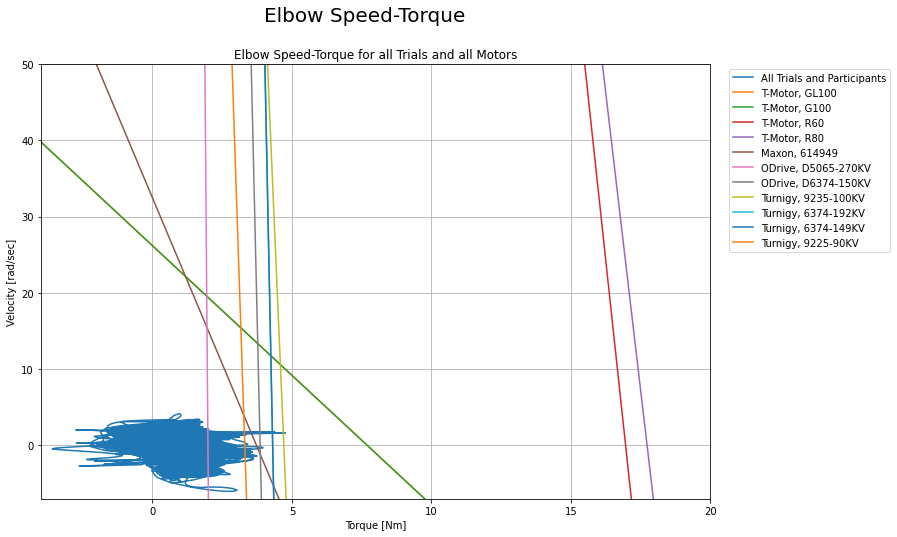

In [26]:
# Compute the torque and speed vectors of the arm's motion for all trials
tot_dtheta1_list = []
tot_dtheta2_list = []
tot_tau1_list = []
tot_tau2_list = []
    
for lst in range(len(time_list)):
    for i in range(len(time_list[lst])):
        tot_dtheta1_list.append(Shl_Flex_Vel_list[lst][i])
        tot_dtheta2_list.append(Elbow_Vel_list[lst][i])
        tot_tau1_list.append(Shl_Flex_tau_list[lst][i])
        tot_tau2_list.append(Elbow_tau_list[lst][i])

# Compute the torque and speed vectors of some motors
######################################## T-Motor ########################################
# T-Motor, GL80 (KV30):
tau_stall_GL80_30 = 1.75
no_load_speed_GL80_30 = 720*2*pi/60
motor_speed_GL80_30 = [2*no_load_speed_GL80_30, no_load_speed_GL80_30, 0, -.5*no_load_speed_GL80_30]
motor_torque_GL80_30 = [-tau_stall_GL80_30, 0, tau_stall_GL80_30, 1.5*tau_stall_GL80_30]

# T-Motor, GL80 (KV60):
tau_stall_GL80_60 = 2.9
no_load_speed_GL80_60 = 1440*2*pi/60
motor_speed_GL80_60 = [2*no_load_speed_GL80_60, no_load_speed_GL80_60, 0, -.5*no_load_speed_GL80_60]
motor_torque_GL80_60 = [-tau_stall_GL80_60, 0, tau_stall_GL80_60, 1.5*tau_stall_GL80_60]

# T-Motor, G80 (KV30):
tau_stall_G80_30 = 2.9
no_load_speed_G80_30 = 700*2*pi/60
motor_speed_G80_30 = [2*no_load_speed_G80_30, no_load_speed_G80_30, 0, -.5*no_load_speed_G80_30]
motor_torque_G80_30 = [-tau_stall_G80_30, 0, tau_stall_G80_30, 1.5*tau_stall_G80_30]

# T-Motor, G80 (KV60):
tau_stall_G80_60 = 2.9
no_load_speed_G80_60 = 1400*2*pi/60
motor_speed_G80_60 = [2*no_load_speed_G80_60, no_load_speed_G80_60, 0, -.5*no_load_speed_G80_60]
motor_torque_G80_60 = [-tau_stall_G80_60, 0, tau_stall_G80_60, 1.5*tau_stall_G80_60]

# T-Motor, GL60 (KV25):
tau_stall_GL60_25 = 1.75
no_load_speed_GL60_25 = 600*2*pi/60
motor_speed_GL60_25 = [2*no_load_speed_GL60_25, no_load_speed_GL60_25, 0, -.5*no_load_speed_GL60_25]
motor_torque_GL60_25 = [-tau_stall_GL60_25, 0, tau_stall_GL60_25, 1.5*tau_stall_GL60_25]

# T-Motor, GL60 (KV55):
tau_stall_GL60_55 = 1.75
no_load_speed_GL60_55 = 1200*2*pi/60
motor_speed_GL60_55 = [2*no_load_speed_GL60_55, no_load_speed_GL60_55, 0, -.5*no_load_speed_GL60_55]
motor_torque_GL60_55 = [-tau_stall_GL60_55, 0, tau_stall_GL60_55, 1.5*tau_stall_GL60_55]

# T-Motor, GL100 (KV10):
tau_stall_GL100 = 7.7
no_load_speed_GL100 = 250*2*pi/60
motor_speed_GL100 = [2*no_load_speed_GL100, no_load_speed_GL100, 0, -.5*no_load_speed_GL100]
motor_torque_GL100 = [-tau_stall_GL100, 0, tau_stall_GL100, 1.5*tau_stall_GL100]

# T-Motor, G100 (KV10):
tau_stall_G100 = 7.7
no_load_speed_G100 = 250*2*pi/60
motor_speed_G100 = [2*no_load_speed_G100, no_load_speed_G100, 0, -.5*no_load_speed_G100]
motor_torque_G100 = [-tau_stall_G100, 0, tau_stall_G100, 1.5*tau_stall_G100]

# T-Motor, R60 (KV115):
tau_stall_R60 = 16.96
no_load_speed_R60 = 5520*2*pi/60
motor_speed_R60 = [2*no_load_speed_R60, no_load_speed_R60, 0, -.5*no_load_speed_R60]
motor_torque_R60 = [-tau_stall_R60, 0, tau_stall_R60, 1.5*tau_stall_R60]

# T-Motor, R80 (KV110):
tau_stall_R80 = 17.73
no_load_speed_R80 = 5280*2*pi/60
motor_speed_R80 = [2*no_load_speed_R80, no_load_speed_R80, 0, -.5*no_load_speed_R80]
motor_torque_R80 = [-tau_stall_R80, 0, tau_stall_R80, 1.5*tau_stall_R80]

# T-Motor, AK60-6:
tau_stall_AK60_6 = 37.49
no_load_speed_AK60_6 = 560*2*pi/60
motor_speed_AK60_6 = [2*no_load_speed_AK60_6, no_load_speed_AK60_6, 0, -.5*no_load_speed_AK60_6]
motor_torque_AK60_6 = [-tau_stall_AK60_6, 0, tau_stall_AK60_6, 1.5*tau_stall_AK60_6]

# T-Motor, AK80-6:
tau_stall_AK80_6 = 80.888
no_load_speed_AK80_6 = 460*2*pi/60
motor_speed_AK80_6 = [2*no_load_speed_AK80_6, no_load_speed_AK80_6, 0, -.5*no_load_speed_AK80_6]
motor_torque_AK80_6 = [-tau_stall_AK80_6, 0, tau_stall_AK80_6, 1.5*tau_stall_AK80_6]

######################################## Maxon ########################################
# Maxon, 614949:
tau_stall_614949 = 4.3
no_load_speed_614949 = 4300*2*pi/60
motor_speed_614949 = [2*no_load_speed_614949, no_load_speed_614949, 0, -.5*no_load_speed_614949]
motor_torque_614949 = [-tau_stall_614949, 0, tau_stall_614949, 1.5*tau_stall_614949]

######################################## E-S Motor ########################################
# E-S Motor, 28PG-385SP-19-EN:
tau_stall_28PG = 3.73
no_load_speed_28PG = 310*2*pi/60
motor_speed_28PG = [2*no_load_speed_28PG, no_load_speed_28PG, 0, -.5*no_load_speed_28PG]
motor_torque_28PG = [-tau_stall_28PG, 0, tau_stall_28PG, 1.5*tau_stall_28PG]

# E-S Motor, 36GP-555PM-51-EN 24V:
tau_stall_36GP_51 = 4.90
no_load_speed_36GP_51 = 230*2*pi/60
motor_speed_36GP_51 = [2*no_load_speed_36GP_51, no_load_speed_36GP_51, 0, -.5*no_load_speed_36GP_51]
motor_torque_36GP_51 = [-tau_stall_36GP_51, 0, tau_stall_36GP_51, 1.5*tau_stall_36GP_51]

# E-S Motor, 36GP-555PM-100-EN 24V:
tau_stall_36GP_100 = 4.90
no_load_speed_36GP_100 = 120*2*pi/60
motor_speed_36GP_100 = [2*no_load_speed_36GP_100, no_load_speed_36GP_100, 0, -.5*no_load_speed_36GP_100]
motor_torque_36GP_100 = [-tau_stall_36GP_100, 0, tau_stall_36GP_100, 1.5*tau_stall_36GP_100]

# E-S Motor, 36GP-555PM-139-EN 24V:
tau_stall_36GP_139 = 4.90
no_load_speed_36GP_139 = 85*2*pi/60
motor_speed_36GP_139 = [2*no_load_speed_36GP_139, no_load_speed_36GP_139, 0, -.5*no_load_speed_36GP_139]
motor_torque_36GP_139 = [-tau_stall_36GP_139, 0, tau_stall_36GP_139, 1.5*tau_stall_36GP_139]

######################################## Pololu ########################################
# Pololu, 150:1 Metal Gearmotor 37Dx73L mm 12V with 64 CPR Encoder (Helical Pinion):
tau_stall_37D__12V_150 = 4.805
no_load_speed_37D__12V_150 = 67*2*pi/60
motor_speed_37D__12V_150 = [2*no_load_speed_37D__12V_150, no_load_speed_37D__12V_150, 0, -.5*no_load_speed_37D__12V_150]
motor_torque_37D__12V_150 = [-tau_stall_37D__12V_150, 0, tau_stall_37D__12V_150, 1.5*tau_stall_37D__12V_150]

# Pololu, 131:1 Metal Gearmotor 37Dx73L mm 12V with 64 CPR Encoder (Helical Pinion):
tau_stall_37D__12V_131 = 4.41
no_load_speed_37D__12V_131 = 76*2*pi/60
motor_speed_37D__12V_131 = [2*no_load_speed_37D__12V_131, no_load_speed_37D__12V_131, 0, -.5*no_load_speed_37D__12V_131]
motor_torque_37D__12V_131 = [-tau_stall_37D__12V_131, 0, tau_stall_37D__12V_131, 1.5*tau_stall_37D__12V_131]

# Pololu, 150:1 Metal Gearmotor 37Dx73L mm 24V with 64 CPR Encoder (Helical Pinion):
tau_stall_37D__24V_150 = 5.49
no_load_speed_37D__24V_150 = 68*2*pi/60
motor_speed_37D__24V_150 = [2*no_load_speed_37D__24V_150, no_load_speed_37D__24V_150, 0, -.5*no_load_speed_37D__24V_150]
motor_torque_37D__24V_150 = [-tau_stall_37D__24V_150, 0, tau_stall_37D__24V_150, 1.5*tau_stall_37D__24V_150]

# Pololu, 131:1 Metal Gearmotor 37Dx73L mm 24V with 64 CPR Encoder (Helical Pinion):
tau_stall_37D__24V_131 = 4.61
no_load_speed_37D__24V_131 = 79*2*pi/60
motor_speed_37D__24V_131 = [2*no_load_speed_37D__24V_131, no_load_speed_37D__24V_131, 0, -.5*no_load_speed_37D__24V_131]
motor_torque_37D__24V_131 = [-tau_stall_37D__24V_131, 0, tau_stall_37D__24V_131, 1.5*tau_stall_37D__24V_131]

# ODrive, DUAL SHAFT MOTOR - D5065 270KV:
tau_stall_D5065 = 1.99
no_load_speed_D5065 = 8640*2*pi/60
motor_speed_D5065 = [2*no_load_speed_D5065, no_load_speed_D5065, 0, -.5*no_load_speed_D5065]
motor_torque_D5065 = [-tau_stall_D5065, 0, tau_stall_D5065, 1.5*tau_stall_D5065]

# ODrive, DUAL SHAFT MOTOR - D6374 150KV:
tau_stall_D6374 = 3.86
no_load_speed_D6374 = 5760*2*pi/60
motor_speed_D6374 = [2*no_load_speed_D6374, no_load_speed_D6374, 0, -.5*no_load_speed_D6374]
motor_torque_D6374 = [-tau_stall_D6374, 0, tau_stall_D6374, 1.5*tau_stall_D6374]

# Turnigy, 9235-100KV Brushless Multi-Rotor Motor:
tau_stall_9235 = 4.71
no_load_speed_9235 = 3840*2*pi/60
motor_speed_9235 = [2*no_load_speed_9235, no_load_speed_9235, 0, -.5*no_load_speed_9235]
motor_torque_9235 = [-tau_stall_9235, 0, tau_stall_9235, 1.5*tau_stall_9235]

# Turnigy, SK8 6374-192KV Sensored Brushless Motor (14P):
tau_stall_6374_192KV = 4.31
no_load_speed_6374_192KV = 7373*2*pi/60
motor_speed_6374_192KV = [2*no_load_speed_6374_192KV, no_load_speed_6374_192KV, 0, -.5*no_load_speed_6374_192KV]
motor_torque_6374_192KV = [-tau_stall_6374_192KV, 0, tau_stall_6374_192KV, 1.5*tau_stall_6374_192KV]

# Turnigy, SK8 6374-149KV Sensored Brushless Motor (14P):
tau_stall_6374_149KV = 4.31
no_load_speed_6374_149KV = 7373*2*pi/60
motor_speed_6374_149KV = [2*no_load_speed_6374_149KV, no_load_speed_6374_149KV, 0, -.5*no_load_speed_6374_149KV]
motor_torque_6374_149KV = [-tau_stall_6374_149KV, 0, tau_stall_6374_149KV, 1.5*tau_stall_6374_149KV]

# Turnigy, 9225-90KV Turnigy Multistar Brushless Multi-Rotor Motor:
tau_stall_9225 = 3.31
no_load_speed_9225 = 3456*2*pi/60
motor_speed_9225 = [2*no_load_speed_9225, no_load_speed_9225, 0, -.5*no_load_speed_9225]
motor_torque_9225 = [-tau_stall_9225, 0, tau_stall_9225, 1.5*tau_stall_9225]

# Plotting the torque-speed curves of the arm's motion and the motors
plt.figure(figsize=(12,8))
plt.plot(tot_tau2_list, tot_dtheta2_list, label='All Trials and Participants')
# plt.plot(motor_torque_GL80_60, motor_speed_GL80_60, 'black', label='T-Motor, GL80 KV60')
# plt.plot(motor_torque_GL80_30, motor_speed_GL80_30, 'black', label='T-Motor, GL80 KV30')
# plt.plot(motor_torque_G80_60, motor_speed_G80_60, 'black', label='T-Motor, G80 KV60')
# plt.plot(motor_torque_G80_30, motor_speed_G80_30, 'black', label='T-Motor, G80 KV30')
# plt.plot(motor_torque_GL60_25, motor_speed_GL60_25, 'black', label='T-Motor, GL60 KV25')
# plt.plot(motor_torque_GL60_55, motor_speed_GL60_55, 'black', label='T-Motor, GL60 KV55')
plt.plot(motor_torque_GL100, motor_speed_GL100, label='T-Motor, GL100')
plt.plot(motor_torque_G100, motor_speed_G100, label='T-Motor, G100')
plt.plot(motor_torque_R60, motor_speed_R60, label='T-Motor, R60')
plt.plot(motor_torque_R80, motor_speed_R80, label='T-Motor, R80')
# plt.plot(motor_torque_AK60_6, motor_speed_AK60_6, label='T-Motor, AK60-6')
# plt.plot(motor_torque_AK80_6, motor_speed_AK80_6, label='T-Motor, AK80-6')
plt.plot(motor_torque_28PG, motor_speed_28PG, label='Maxon, 614949')
# plt.plot(motor_torque_28PG, motor_speed_28PG, label='E-S Motor, 28PG-385SP-19-EN')
# plt.plot(motor_torque_36GP_51, motor_speed_36GP_51, label='E-S Motor, 36GP-555PM-51-EN 24V')
# plt.plot(motor_torque_36GP_100, motor_speed_36GP_100, label='E-S Motor, 36GP-555PM-100-EN 24V')
# plt.plot(motor_torque_36GP_139, motor_speed_36GP_139, label='E-S Motor, 36GP-555PM-139-EN 24V')
# plt.plot(motor_torque_37D__12V_150, motor_speed_37D__12V_150, label='Pololu, 37D__12V_150')
# plt.plot(motor_torque_37D__12V_131, motor_speed_37D__12V_150, label='Pololu, 37D__12V_131')
# plt.plot(motor_torque_37D__24V_150, motor_speed_37D__24V_150, label='Pololu, 37D__24V_150')
# plt.plot(motor_torque_37D__24V_131, motor_speed_37D__24V_150, label='Pololu, 37D__24V_131')
plt.plot(motor_torque_D5065, motor_speed_D5065, label='ODrive, D5065-270KV')
plt.plot(motor_torque_D6374, motor_speed_D6374, label='ODrive, D6374-150KV')
plt.plot(motor_torque_9235, motor_speed_9235, label='Turnigy, 9235-100KV')
plt.plot(motor_torque_6374_192KV, motor_speed_6374_192KV, label='Turnigy, 6374-192KV')
plt.plot(motor_torque_6374_149KV, motor_speed_6374_149KV, label='Turnigy, 6374-149KV')
plt.plot(motor_torque_9225, motor_speed_9225, label='Turnigy, 9225-90KV')

plt.ylabel('Velocity [rad/sec]')
plt.xlabel('Torque [Nm]')
plt.xlim([-4, 20])
plt.ylim([-7, 50])
plt.grid()
plt.legend(loc='upper left', bbox_to_anchor=(1.02,1))
plt.suptitle('Elbow Speed-Torque', fontsize=20)
plt.title('Elbow Speed-Torque for all Trials and all Motors')
plt.show()